In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    brier_score_loss,
    confusion_matrix
)


In [2]:

# ==========================================
# 1. SYNTHETIC DATA GENERATION (PROBABILISTIC)
# ==========================================
def generate_synthetic_data(n=2000, seed=42):
    """
    Generates data using a logistic (sigmoid) function to simulate 
    realistic human behavior (churn risk).
    """
    np.random.seed(seed)
    
    usage = np.random.normal(50, 15, n)
    support_calls = np.random.randint(0, 10, n)
    tenure = np.random.randint(1, 60, n)

    # Calculate log-odds (Risk Score)
    # Logic: More calls = +Risk | Higher usage/tenure = -Risk
    logit = (0.6 * support_calls) - (0.07 * usage) - (0.03 * tenure) + 1.5
    probabilities = 1 / (1 + np.exp(-logit))

    # Sample churn based on probabilities (adds natural noise)
    churn = (np.random.random(n) < probabilities).astype(int)

    return pd.DataFrame({
        "usage": usage,
        "support_calls": support_calls, 
        "tenure": tenure, 
        "churn": churn
    })



In [3]:
# ==========================================
# 2. PROFESSIONAL CHURN PREDICTOR CLASS
# ==========================================
class ChurnPredictor:
    def __init__(self):
        self.features = ["usage", "support_calls", "tenure", "usage_per_call"]
        self.model = None
        
    def _engineer_features(self, df):
        """Standardized feature engineering for train and inference."""
        df = df.copy()
        df["usage_per_call"] = df["usage"] / (df["support_calls"] + 1)
        return df[self.features]

    def build_pipeline(self):
        """Creates a pipeline that scales data before training."""
        return Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', GradientBoostingClassifier(
                n_estimators=100, 
                learning_rate=0.1, 
                max_depth=3, 
                random_state=42
            ))
        ])

    def train(self, X_train, y_train):
        """Trains a model calibrated for accurate probability output."""
        X_eng = self._engineer_features(X_train)
        base_pipeline = self.build_pipeline()
        
        # CalibratedClassifierCV ensures probabilities represent real-world frequencies
        self.model = CalibratedClassifierCV(base_pipeline, cv=5, method='sigmoid')
        self.model.fit(X_eng, y_train)
        
    def predict_risk(self, X):
        """Returns the probability of churn (0.0 to 1.0)."""
        X_eng = self._engineer_features(X)
        return self.model.predict_proba(X_eng)[:, 1]

    def predict_class(self, X):
        """Returns the final binary prediction (0 or 1)."""
        X_eng = self._engineer_features(X)
        return self.model.predict(X_eng)



In [4]:
# ==========================================
# 3. EVALUATION AND MONITORING
# ==========================================
def evaluate_model(predictor, X_test, y_test):
    """Generates a business-ready performance report."""
    y_prob = predictor.predict_risk(X_test)
    y_pred = predictor.predict_class(X_test)
    
    print("--- Classification Report ---")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
    print(f"Brier Score (Closer to 0 is better calibration): {brier_score_loss(y_test, y_prob):.4f}")

    # Plot Visual Evaluations
    plt.figure(figsize=(12, 5))
    
    # Calibration Curve
    plt.subplot(1, 2, 1)
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, "s-", label="Predictor")
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Actual Fraction of Churn")
    plt.title("Reliability Diagram (Calibration)")
    plt.legend()

    # Confusion Matrix
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    
    plt.tight_layout()
    plt.show()



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       214
           1       0.77      0.71      0.74       186

    accuracy                           0.77       400
   macro avg       0.77      0.76      0.76       400
weighted avg       0.77      0.77      0.76       400

ROC-AUC Score: 0.8489
Brier Score (Closer to 0 is better calibration): 0.1595


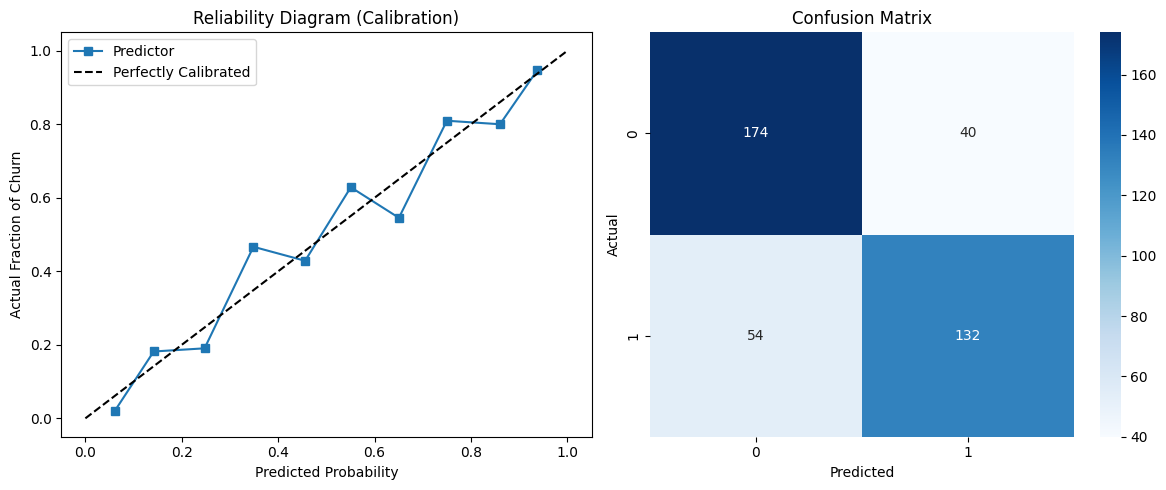

In [5]:
# ==========================================
# 4. MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    # 1. Data Collection
    data = generate_synthetic_data(n=2000)

    # 2. Data Preparation
    X = data.drop("churn", axis=1)
    y = data["churn"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 3. Model Training
    predictor = ChurnPredictor()
    predictor.train(X_train, y_train)

    # 4. Performance Check
    evaluate_model(predictor, X_test, y_test)